## Install all the dependencies

In [1]:
!pip install -q fastai torch timm kaggle
import numpy as np
import pandas as pd 
import os
import timm
import torch
from pathlib import Path
from fastai.vision.all import *
import shutil
from google.colab import files

## Download Datasets from Kaggle

In [ ]:
files.upload() # upload your kaggle.json here

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ma7555/cat-breeds-dataset
!unzip -q cat-breeds-dataset.zip -d cat
!rm cat-breeds-dataset.zip
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
!unzip -q stanford-dogs-dataset.zip -d dog
!rm stanford-dogs-dataset.zip

100% 1.92G/1.93G [00:17<00:00, 147MB/s]
100% 1.93G/1.93G [00:17<00:00, 117MB/s]
 98% 736M/750M [00:06<00:00, 94.3MB/s]
100% 750M/750M [00:06<00:00, 122MB/s] 


## EDA and cleaning Data

In [5]:
cat_df = pd.read_csv('/content/cat/data/cats.csv')
cat_df.head()

,Unnamed: 0,id,url,type,age,gender,size,coat,breed,photos,med_photos
0,0,46744842,https://www.petfinder.com/cat/arianna-46744842/ny/port-chester/nyc-bronx-westchester-cat-coalition-nyc-cat-coalition-ny622/?referrer_id=3830981a-ad4c-4f85-872c-ca9edc50a67e,Cat,Adult,Female,Medium,NaN,Abyssinian,"[{'small': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/1/?bust=1575403984&width=100', 'medium': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/1/?bust=1575403984&width=300', 'large': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/1/?bust=1575403984&width=600', 'full': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/1/?bust=1575403984'}, {'small': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/3/?bust=1575403984&width=100', 'medium': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/3/?bust=1575403984&width=300', 'large'...","['https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/1/?bust=1575403984&width=300', 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/3/?bust=1575403984&width=300', 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46744842/2/?bust=1575403984&width=300']"
1,1,46717321,https://www.petfinder.com/cat/ozzy-46717321/oh/zanesville/the-animal-shelter-society-inc-oh181/?referrer_id=3830981a-ad4c-4f85-872c-ca9edc50a67e,Cat,Adult,Male,Extra Large,NaN,Abyssinian,"[{'small': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46717321/1/?bust=1575099676&width=100', 'medium': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46717321/1/?bust=1575099676&width=300', 'large': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46717321/1/?bust=1575099676&width=600', 'full': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46717321/1/?bust=1575099676'}]",['https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46717321/1/?bust=1575099676&width=300']
2,2,46626338,https://www.petfinder.com/cat/zena-46626338/ca/santa-barbara/santa-barbara-county-animal-services-santa-barbara-shelter-ca63/?referrer_id=3830981a-ad4c-4f85-872c-ca9edc50a67e,Cat,Senior,Female,Medium,NaN,Abyssinian,"[{'small': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46626338/1/?bust=1575423383&width=100', 'medium': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46626338/1/?bust=1575423383&width=300', 'large': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46626338/1/?bust=1575423383&width=600', 'full': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46626338/1/?bust=1575423383'}]",['https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46626338/1/?bust=1575423383&width=300']
3,3,46620170,https://www.petfinder.com/cat/mika-46620170/ca/la-puente/vida-rescue-ca2713/?referrer_id=3830981a-ad4c-4f85-872c-ca9edc50a67e,Cat,Baby,Female,Small,Short,Abyssinian,"[{'small': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/1/?bust=1574168525&width=100', 'medium': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/1/?bust=1574168525&width=300', 'large': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/1/?bust=1574168525&width=600', 'full': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/1/?bust=1574168525'}, {'small': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/2/?bust=1574168528&width=100', 'medium': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/2/?bust=1574168528&width=300', 'large'...","['https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/1/?bust=1574168525&width=300', 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/2/?bust=1574168528&width=300', 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/3/?bust=1574339804&width=300', 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46620170/4/?bust=1574339805&width=300']"
4,4,46582751,https://www.petfinder.com/cat/ruby-46582751/fl/titusville/spca-of-brevard-fl76/?referrer_id=3830981a-ad4c-4f85-872c-ca9edc50a67e,Cat,Young,Female,Medium,NaN,Abyssinian,"[{'small': 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/46582751/1/?bust=1575359381&width=100', 'medium': 'ht

In [6]:
breed_count= cat_df.breed.value_counts().sort_values()
breed_count[:20]

York Chocolate          1
Chinchilla              3
Canadian Hairless       4
Burmilla                8
Cymric                 17
LaPerm                 18
Singapura              22
American Wirehair      23
Chausie                23
Javanese               27
Somali                 36
Oriental Long Hair     39
Korat                  70
Selkirk Rex            76
Chartreux              86
Silver                 94
Oriental Tabby        103
Pixiebob              111
Devon Rex             119
Ocicat                121
Name: breed, dtype: int64

In [7]:
remove_breed =breed_count.loc[breed_count <40]
remove_breed.index

Index(['York Chocolate', 'Chinchilla', 'Canadian Hairless', 'Burmilla',
       'Cymric', 'LaPerm', 'Singapura', 'American Wirehair', 'Chausie',
       'Javanese', 'Somali', 'Oriental Long Hair'],
      dtype='object')

In [8]:
path_to_remove = Path('/content/cat/images')
for breed in remove_breed.index:
  remove_folder = path_to_remove/breed
  shutil.rmtree(remove_folder)

!rm -r ./dog/annotations

### rename path
    Add '_' between the breed name with the parent directory to make a PipeLine DalaLoader

In [9]:
dog_path = Path('/content/dog/images/Images')
cat_path = Path('/content/cat/images')

for folder in os.listdir(dog_path):
  old_path = dog_path/folder
  new_path = dog_path/ ('dog_' + folder[10:].replace('_', ' '))
  os.rename(old_path,new_path)

for folder in os.listdir(cat_path):
  old_path = cat_path/folder
  new_path = cat_path/ ('cat_' + folder)
  os.rename(old_path,new_path)

#### reorganize folder
    Move cat's path and dog's path to the Train path

In [10]:
new_path = Path('/content/Train')
os.mkdir(new_path)

for folder in os.listdir(dog_path):
  shutil.move(dog_path/folder, new_path)

for folder in os.listdir(cat_path):
  shutil.move(cat_path/folder, new_path)


## build DataLoaders

In [11]:
train_path = new_path

In [12]:
# Split the parent's name with '_' to get the breed
def get_y(path): return path.parent.name.split('_')

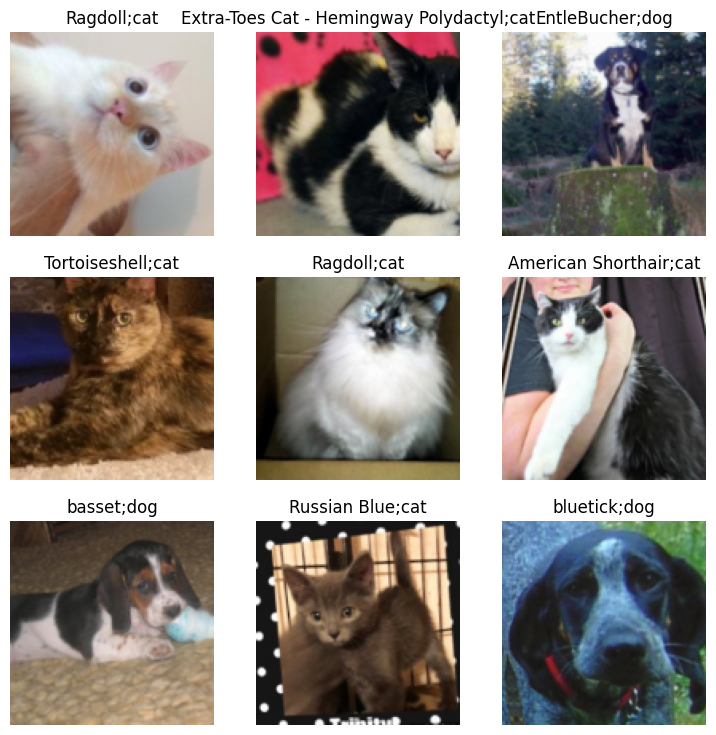

In [13]:
dblock = DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                   get_items=get_image_files,
                   get_y=get_y,
                   splitter= RandomSplitter(0.2),
                   item_tfms=Resize(192, method='Squish'),
                   batch_tfms= aug_transforms(size= 128, min_scale=0.75)
                   )

dls = dblock.dataloaders(train_path)
dls.show_batch(max_n=9)

## Defind the Model with aproriate metric and loss function

In [15]:
arch = 'convnext_base'
loss_func = nn.BCEWithLogitsLoss()
metrics = partial(accuracy_multi, thresh=0.5)

learn = vision_learner(dls,arch=arch,loss_func=loss_func, metrics=metrics)

In [16]:
learn.fine_tune(3,2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.016186,0.014242,0.995357,04:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.014362,0.012745,0.995691,07:48
1,0.013406,0.012245,0.995789,07:47
2,0.012810,0.012051,0.995847,07:48


In [18]:
pred = learn.predict('test1.jpg')
pred[1]

tensor([-14.3755, -16.8145, -12.2537, -13.2317, -13.0566, -13.6726, -10.9582,
        -16.2315, -11.5277, -11.5917, -14.0313, -15.1079, -18.4454,  -9.7855,
        -15.6659, -15.2529, -11.9140, -18.1848, -17.9444, -14.6078, -12.6668,
        -15.3737,  -9.1649, -12.3028, -16.8392, -12.0747, -14.0543, -15.7434,
        -18.6051, -12.8930, -11.8165, -23.0981, -16.2079, -17.4954, -16.3535,
        -16.8618, -19.7405, -16.0361, -12.8314,  -9.1102, -14.0229, -13.8948,
        -14.6428, -14.5644, -13.1243, -13.4763, -13.4000, -13.6640, -10.2837,
        -16.2403, -14.7388, -13.1581, -21.3224, -16.5842, -16.4889, -15.3540,
        -15.4996, -20.6441, -14.9619, -16.0734, -15.9132, -15.0243, -16.9339,
        -13.9906, -13.1091, -12.8964, -15.9379, -11.8460, -14.6673, -15.5262,
        -13.9141, -18.3477, -16.4666, -11.1796, -17.7122, -14.0437, -18.7907,
        -17.0742, -13.6719, -17.9548,  -6.3827, -16.6867, -14.1941, -18.9520,
        -13.4759, -14.9386,  -8.7017, -15.6806, -15.9306, -17.37

In [19]:
predict = torch.where(pred[1].sigmoid()>0.5)[0]
predict

tensor([149, 165])

In [20]:
learn.dls.vocab

['Abyssinian', 'Afghan hound', 'African hunting dog', 'Airedale', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Staffordshire terrier', 'Appenzeller', 'Applehead Siamese', 'Australian terrier', 'Balinese', 'Bedlington terrier', 'Bengal', 'Bernese mountain dog', 'Birman', 'Blenheim spaniel', 'Bombay', 'Border collie', 'Border terrier', 'Boston bull', 'Bouvier des Flandres', 'Brabancon griffon', 'British Shorthair', 'Brittany spaniel', 'Burmese', 'Calico', 'Cardigan', 'Chartreux', 'Chesapeake Bay retriever', 'Chihuahua', 'Cornish Rex', 'Dandie Dinmont', 'Devon Rex', 'Dilute Calico', 'Dilute Tortoiseshell', 'Doberman', 'Domestic Long Hair', 'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau', 'English foxhound', 'English setter', 'English springer', 'EntleBucher', 'Eskimo dog', 'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl', 'French bulldog', 'German shepherd', 'German short-haired pointer', 'Gordon setter', 'Great Dane', 'Great Pyrenees', 'Gr

In [21]:
learn.dls.vocab[predict]

(#2) ['dog','pug']

In [53]:
categories = learn.dls.vocab

def tensor2labels(img):
    output = learn.predict(img)
    index = torch.where(output[1].sigmoid()>0.4)[0]
    category = categories[index]
    if 'dog' in category:
        category.remove('dog')
        if len(category)==0:
           return f"This is a Dog and I am not smart enough to know what breed it is :(("
        return f"This is a Dog and belongs to the breed: {category.pop()}"
    elif 'cat' in category:
        category.remove('cat')
        if len(category)==0:
            return f"This is a Cat and I am not smart enough to know what breed it is :(("
        return f"This is a Cat and belongs to the breed: {category.pop()}"
    else:
      raise Exception
